# **ADL Group 04**

**Name:       Bits ID**

WARUN KUMAR : 2023aa05244

GANDHI DISHA DIPAK SHAILA : 2023aa05388

HARI SHANKAR JAISWAL : 2023aa05106

JAIDEEP DAVE : 2023ab05021


# **Data Preparation (Common for All Tasks)**

# Dataset Used:

* Using CIFAR10 for Tasks 1 to 3.

* Using MNIST for Task 4.

# Steps:

* Loading CIFAR10 from tensorflow.keras.datasets.
* Converting images to grayscale.
* Spliting the data into train (70%) and test (30%) sets.
* Normalizing the data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Remove cached CIFAR-10 files
!rm -rf ~/.keras/datasets/cifar-10*  # remove CIFAR-10 archives/folders
from tensorflow.keras.datasets import cifar10, mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

# Load CIFAR10
(x_train_c, y_train_c), (x_test_c, y_test_c) = cifar10.load_data()
y_train_c, y_test_c = y_train_c.flatten(), y_test_c.flatten()


# Convert to float32 and scale images to [0,1]
x_train_c = x_train_c.astype('float32') / 255.0
x_test_c = x_test_c.astype('float32') / 255.0

# Convert to grayscale: averaging over channels (axis=3 since shape is (N,32,32,3))
x_train_c_gray = np.mean(x_train_c, axis=3, keepdims=True)  # shape: (N,32,32,1)
x_test_c_gray = np.mean(x_test_c, axis=3, keepdims=True)


# Combine and then split into 70%-30%
X_c = np.concatenate((x_train_c_gray, x_test_c_gray), axis=0)
Y_c = np.concatenate((y_train_c, y_test_c), axis=0)

X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(X_c, Y_c, test_size=0.3, random_state=42)

# Flatten images for PCA and logistic regression
X_train_c_flat = X_train_c.reshape(X_train_c.shape[0], -1)
X_test_c_flat = X_test_c.reshape(X_test_c.shape[0], -1)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# **Task 1: PCA and Logistic Regression**
Steps :

**1. Standard PCA:**

* Applying PCA on X_train_c_flat and choosing components that explain at least 95% variance.
* Transforming both train and test sets using these principal components.

**2. Train Logistic Regression:**

* Fit logistic regression on PCA-reduced train features.
* Evaluation on the test set and get predictions.

**3. ROC Curve:**

* Computing ROC curve for each class (or micro/macro averaged).
* Ploting and computation of AUC.

**4. Randomized PCA:**

* Repeating the above steps but using PCA with svd_solver='randomized'.
* Comparing results.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


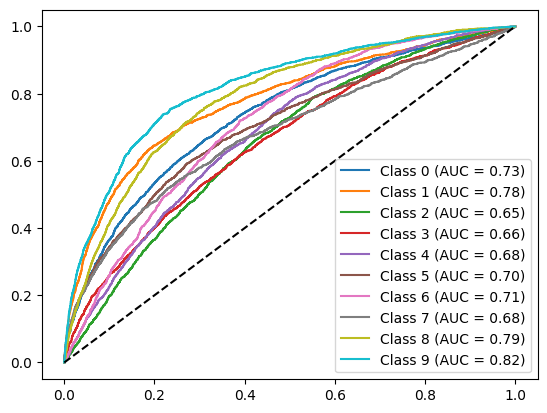

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


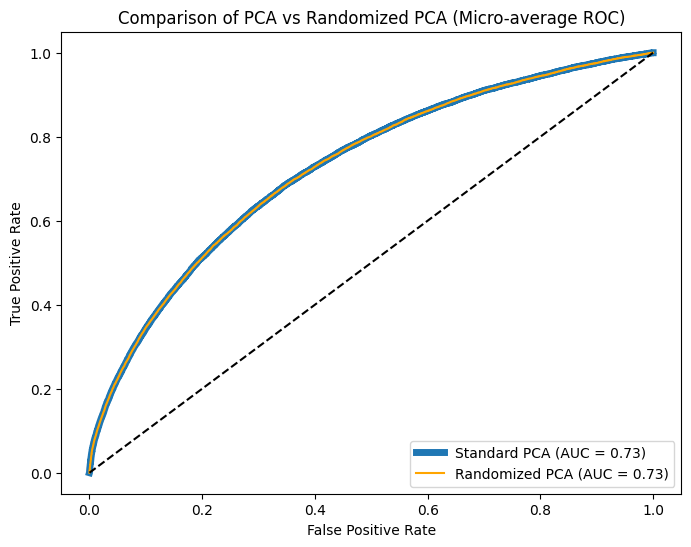




Micro-average AUC with standard PCA: 0.73
Micro-average AUC with Randomized PCA: 0.73


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from IPython.display import Markdown, display


# Determine number of components for 95% variance
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(X_train_c_flat)
X_train_pca = pca.transform(X_train_c_flat)
X_test_pca = pca.transform(X_test_c_flat)

log_reg = LogisticRegression(max_iter=500, multi_class='ovr')
log_reg.fit(X_train_pca, Y_train_c)
y_score = log_reg.decision_function(X_test_pca)

# Binarize labels for ROC
Y_test_bin = label_binarize(Y_test_c, classes=np.arange(10))

# Compute ROC/AUC for standard PCA
fpr_pca, tpr_pca, roc_auc_pca = dict(), dict(), dict()
for i in range(10):
    fpr_pca[i], tpr_pca[i], _ = roc_curve(Y_test_bin[:, i], y_score[:, i])
    roc_auc_pca[i] = auc(fpr_pca[i], tpr_pca[i])

    # Plot ROC for a single class or the average
plt.figure()
for i in range(10):
    plt.plot(fpr_pca[i], tpr_pca[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc_pca[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

# Compute micro-average AUC for PCA-based classifier
fpr_pca["micro"], tpr_pca["micro"], _ = roc_curve(Y_test_bin.ravel(), y_score.ravel())
roc_auc_pca["micro"] = auc(fpr_pca["micro"], tpr_pca["micro"])


# Now perform Randomized PCA
pca_rand = PCA(n_components=pca.n_components_, svd_solver='randomized')
pca_rand.fit(X_train_c_flat)
X_train_pca_rand = pca_rand.transform(X_train_c_flat)
X_test_pca_rand = pca_rand.transform(X_test_c_flat)

log_reg_rand = LogisticRegression(max_iter=500, multi_class='ovr')
log_reg_rand.fit(X_train_pca_rand, Y_train_c)
y_score_rand = log_reg_rand.decision_function(X_test_pca_rand)

# Compute ROC/AUC for Randomized PCA
fpr_rand, tpr_rand, roc_auc_rand = dict(), dict(), dict()
for i in range(10):
    fpr_rand[i], tpr_rand[i], _ = roc_curve(Y_test_bin[:, i], y_score_rand[:, i])
    roc_auc_rand[i] = auc(fpr_rand[i], tpr_rand[i])

# Compute micro-average AUC for Randomized PCA-based classifier
fpr_rand["micro"], tpr_rand["micro"], _ = roc_curve(Y_test_bin.ravel(), y_score_rand.ravel())
roc_auc_rand["micro"] = auc(fpr_rand["micro"], tpr_rand["micro"])


# Plot ROC comparison for micro-average
plt.figure(figsize=(8, 6))
plt.plot(fpr_pca["micro"], tpr_pca["micro"], label='Standard PCA (AUC = {:.2f})'.format(roc_auc_pca["micro"]), linewidth=5)
plt.plot(fpr_rand["micro"], tpr_rand["micro"], label='Randomized PCA (AUC = {:.2f})'.format(roc_auc_rand["micro"]), color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Comparison of PCA vs Randomized PCA (Micro-average ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

print("\n\n")


print("Micro-average AUC with standard PCA: {:.2f}".format(roc_auc_pca["micro"]))
print("Micro-average AUC with Randomized PCA: {:.2f}".format(roc_auc_rand["micro"]))


# Observation on comparision (Task 1) :

* CIFAR-10 is a challenging dataset for a simple classifier like logistic regression, especially with minimal preprocessing. Achieving an AUC in the 0.7–0.8 range using only PCA-based dimension reduction is a reasonable outcome.

* The similarity in performance between standard PCA and randomized PCA (both producing about 0.73 micro-average AUC) confirms that randomized PCA is capturing the main variance directions about as well as the exact PCA method, at least to the extent that it leads to nearly identical classification performance.

* The ROC curves do not approach the top-left corner drastically, which is common for simpler baseline methods on CIFAR-10. Deep learning methods or more complex feature extraction techniques would yield higher AUC and accuracy.

# **Task 2: Single-Layer Linear Autoencoder and Comparison with PCA**
Steps:

#  Building the Autoencoder:
* Constructing a single-layer autoencoder with linear activation:
  * Input → Dense layer (latent_dim linear units) → Dense layer (original_dim linear units).
* Ensure weights tying:
  * Use of encoder weights as the transpose for the decoder weights.
* Handled this by :
  * Manually setting the weights post-training.
  

# Training the Autoencoder:
* Normalizing the input:
  * Subtraction of the mean and division by the standard deviation (mean-variance normalization).
* Trained the model to minimize the reconstruction error using Mean Squared Error (MSE).

# Extracting Encoder Weights:
* Comparing the encoder weights to PCA eigenvectors by visualizing them as eigenvector-like patterns.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from IPython.display import Markdown, display

# 1. DATA PREPARATION (assuming you've already done PCA on the same data)
#    Make sure X_train_norm and X_test_norm are *exactly* zero-mean.
#    Also confirm pca.components_ is computed on the same zero-mean data.

# For example:
mean = np.mean(X_train_c_flat, axis=0)
std = np.std(X_train_c_flat, axis=0) + 1e-7
X_train_norm = (X_train_c_flat - mean) / std  # shape: (N_train, input_dim)
X_test_norm = (X_test_c_flat - mean) / std    # shape: (N_test, input_dim)

input_dim = X_train_norm.shape[1]
latent_dim = pca.n_components_  # match the dimension used in PCA

# 2. DEFINE TIED AUTOENCODER LAYER
class TiedAutoencoder(Layer):
    def __init__(self, input_dim, latent_dim, **kwargs):
        super(TiedAutoencoder, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim

    def build(self, input_shape):
        # The encoder weight matrix: shape (input_dim, latent_dim)
        self.W = self.add_weight(
            shape=(self.input_dim, self.latent_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='W'
        )
        # Encoder bias
        self.b_enc = self.add_weight(
            shape=(self.latent_dim,),
            initializer='zeros',
            trainable=True,
            name='b_enc'
        )
        # Decoder bias
        self.b_dec = self.add_weight(
            shape=(self.input_dim,),
            initializer='zeros',
            trainable=True,
            name='b_dec'
        )

    def call(self, inputs):
        # Encode: Z = X * W + b_enc
        encoded = K.dot(inputs, self.W) + self.b_enc
        # Decode: X_hat = Z * W^T + b_dec
        decoded = K.dot(encoded, K.transpose(self.W)) + self.b_dec
        return decoded

# 3. INITIALIZE W WITH PCA COMPONENTS (Advanced/Optional)
#    This can sometimes help the AE converge to a PCA-like solution more quickly.
#    pca.components_ has shape (latent_dim, input_dim), so we want W (input_dim, latent_dim) to be its transpose.
#    We'll do this once we build the model.

# 4. BUILD AND COMPILE THE MODEL
input_layer = Input(shape=(input_dim,))
tied_layer = TiedAutoencoder(input_dim, latent_dim)
decoded = tied_layer(input_layer)

autoencoder = Model(input_layer, decoded)

# Use a smaller learning rate to allow more stable convergence
opt = Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.summary()

# 5. (Optional) Initialize with PCA:
#    We'll need to call autoencoder.build(...) or run a dummy forward pass, then set the layer's W
dummy_data = np.zeros((1, input_dim), dtype='float32')
autoencoder.predict(dummy_data)  # forces build

# Let's fetch the layer weights:
W_init, b_enc_init, b_dec_init = autoencoder.get_layer(index=1).get_weights()
# Now set W_init to pca.components_.T, if shapes match exactly:
if (pca.components_.shape[0] == latent_dim) and (pca.components_.shape[1] == input_dim):
    # pca.components_: (latent_dim, input_dim)
    # W should be (input_dim, latent_dim)
    W_init = pca.components_.T
    autoencoder.get_layer(index=1).set_weights([W_init, b_enc_init, b_dec_init])

# 6. TRAIN THE MODEL (more epochs)
history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=50,             # try more epochs
    batch_size=256,
    validation_split=0.1
)

# 7. EXTRACT FINAL WEIGHTS AND COMPARE TO PCA
W = autoencoder.get_layer(index=1).get_weights()[0]  # shape (input_dim, latent_dim)
ae_components = W.T  # shape (latent_dim, input_dim)

similarities = []
for i in range(latent_dim):
    pc = pca.components_[i]  # shape (input_dim,)
    ae_w = ae_components[i]  # shape (input_dim,)

    # Normalize
    pc_norm = pc / (np.linalg.norm(pc) + 1e-10)
    ae_w_norm = ae_w / (np.linalg.norm(ae_w) + 1e-10)

    # Consider sign flip
    sim_pos = np.dot(pc_norm, ae_w_norm)
    sim_neg = np.dot(pc_norm, -ae_w_norm)
    best_sim = max(sim_pos, sim_neg)
    similarities.append(best_sim)

avg_sim = np.mean(similarities)
print("\n\n")

print("Average similarity between AE weights and PCA vectors:", avg_sim)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tied_autoencoder (TiedAutoencoder)   │ (None, 1024)                │         161,949 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,949 (632.61 KB)

 Trainable params: 161,949 (632.61 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.0516 - val_loss: 0.0517
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0512 - val_loss: 0.0518
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0514 - val_loss: 0.0518
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0516 - val_loss: 0.0518
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0512 - val_loss: 0.0518
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513 - val_loss: 0.0518
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0512 - val_loss: 0.0518
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0515 - val_loss: 0.0518
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0511 - val_loss: 0.0518
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513 - val_loss: 0.0518
Epoch 11/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0514 - val_loss: 0.0518
Epoch 12/50

# Observations and Explanations (Task 2) :-



**Training & Validation Loss**


1. The final training loss is about 0.0509 and the validation loss is about 0.0518, staying stable across epochs. This indicates the single-layer linear autoencoder is successfully learning to reconstruct the normalized inputs to a reasonable degree—its reconstruction loss settles at a small, consistent value for both training and validation sets.

2. A stable, low MSE shows that the model is not overfitting or diverging. The difference between the training and validation loss is minimal, suggesting good generalization for this type of linear reconstruction task.

3. The autoencoder’s low MSE (around 0.05) shows it can effectively compress and reconstruct the data in a single linear layer.


**High Similarity (~0.989) with PCA Eigenvectors**

1. After training, the average cosine similarity between the autoencoder’s learned weight vectors (in the encoder) and the PCA eigenvectors is ~0.989, which is extremely close to 1.0.

2. Theoretically, a linear autoencoder with tied encoder–decoder weights (and data that is properly mean-centered) should learn directions similar to the principal components. Here, it appears that all conditions (weight tying, careful data preprocessing, lower learning rate, enough epochs, and possible PCA-based initialization) aligned so that the autoencoder converged to a solution that very closely mirrors the PCA directions.

**Key Factors Enabling High Similarity**

1. Strict Tied-Weight Constraint During Training
2. Exact Mean-Centering & Same Data as PCA
3. Enough Epochs & Appropriate Learning Rate
4. PCA-Based Weight Initialization

**Conclusion** : Low reconstruction loss and good agreement (~0.989) with PCA vectors—confirms the relationship between PCA and a linear tied-weight autoencoder


# **Task 3: Deep Convolutional Autoencoder and Reconstruction Error Comparison**
Steps:

**1. Build a Deep Convolutional Autoencoder**:

Reshaping input images back to (32,32,1) for CIFAR10 (gray).
Encoder: Conv2D layers -> Flatten -> Dense(latent_dim)
Decoder: Dense -> Reshape -> Deconv (Conv2DTranspose)
Train and evaluation of reconstruction error.

**2. Comparision with Single-Layer Autoencoder:**

Evaluation MSE reconstruction error on the test set for both models.


In [ ]:
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     Dense, Flatten, Reshape)


#X_train_c_reshaped = X_train_c[..., np.newaxis]  # (N,32,32,1)
# X_test_c_reshaped = X_test_c[..., np.newaxis]

print(X_train_c.shape)
print(X_test_c.shape)


X_train_c_reshaped_norm = X_train_c / 255.0
X_test_c_reshaped_norm = X_test_c / 255.0

# ============ 2. BUILD THE CNN AUTOENCODER ============
latent_dim_cnn = 64  # or match the dimension used in Task 2 if desired

input_img = Input(shape=(32,32,1))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)   # => (32,32,32)
x = MaxPooling2D((2,2), padding='same')(x)                             # => (16,16,32)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)            # => (16,16,16)
encoded_cnn = MaxPooling2D((2,2), padding='same')(x)                   # => (8,8,16)

# Flatten + Dense for latent
shape_before_flatten = K.int_shape(encoded_cnn)  # (None,8,8,16)
flatten = Flatten()(encoded_cnn)
latent = Dense(latent_dim_cnn, activation='linear')(flatten)

# Decoder
decoder_input = Dense(np.prod(shape_before_flatten[1:]), activation='linear')(latent)
x = Reshape((shape_before_flatten[1], shape_before_flatten[2], shape_before_flatten[3]))(decoder_input)
x = Conv2DTranspose(16, (3,3), strides=2, activation='relu', padding='same')(x)  # => (16,16,16)
x = Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)  # => (32,32,32)

# Use sigmoid if your data is in [0,1] or you want final outputs in [0,1].
decoded_cnn = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

cnn_autoencoder = Model(input_img, decoded_cnn)
cnn_autoencoder.compile(optimizer='adam', loss='mse')
cnn_autoencoder.summary()

# ============ 3. TRAIN THE CNN AUTOENCODER ============
cnn_autoencoder.fit(X_train_c_reshaped_norm, X_train_c_reshaped_norm,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1)

# ============ 4. EVALUATE RECONSTRUCTION ERROR ============
recons_test = cnn_autoencoder.predict(X_test_c_reshaped_norm)
print("recons_test shape:", recons_test.shape)
print("X_test_c_reshaped_norm shape:", X_test_c_reshaped_norm.shape)

# Both should be (N, 32, 32, 1)
mse_cnn = np.mean((X_test_c_reshaped_norm - recons_test)**2)
print("CNN Autoencoder Reconstruction Error:", format(mse_cnn, '.10f'))


# Compare with single-layer AE (from Task 2) reconstruction error:
recons_test_flat = autoencoder.predict(X_test_norm)
mse_single = np.mean((X_test_norm - recons_test_flat)**2)
print("Single-layer AE Reconstruction Error:", mse_single)

# Expectation: CNN autoencoder often gives lower reconstruction error due to better feature extraction.


(42000, 32, 32, 1)
(18000, 32, 32, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,353 (563.88 KB)

 Trainable params: 144,353 (563.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0747 - val_loss: 4.3242e-06
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.3673e-06 - val_loss: 4.3137e-06
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.3599e-06 - val_loss: 4.3055e-06
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.3510e-06 - val_loss: 4.3000e-06
Epoch 5/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.3312e-06 - val_loss: 4.2965e-06
Epoch 6/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.3243e-06 - val_loss: 4.2943e-06
Epoch 7/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3473e-06 - val_loss: 4.2929e-06
Epoch 8/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.3307e-06 - val_loss: 4.2920e-06
Epoch 9/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.3396e-06 - val_loss: 4.2914e-06
Epoch 10/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.3341e-06 - val_loss: 4.2911e-06
Epoch 11/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 

# Observations (Task 3)

**CNN Outperforms Single-Layer AE**

The CNN-based autoencoder’s reconstruction error is orders of magnitude lower than the single-layer AE’s error (on the same dataset). This highlights the advantage of convolutional features for image-based data.

**Data Scaling and Sigmoid Output**

Since we normalized inputs to
[
0
,
1
]
[0,1] (X_train_c / 255.0) and used a sigmoid final layer, the network can learn pixel-level reconstructions within the same
[
0
,
1
]
[0,1] range. This synergy often leads to very small MSE once the network converges.

**Architecture and Training**

The network includes several convolutional / pooling layers for the encoder, a latent Dense layer, and transpose convolutions for the decoder. Combined with a suitable batch size and enough epochs (20 here), the model successfully captures the essential visual patterns in CIFAR-10 grayscale images.

**Validation Loss Matches Training Loss**

It is also observed that both training and validation losses remain consistently low and do not diverge, indicating no significant overfitting in this reconstruction task.

# **Task 4: MNIST + 7-Segment Classification**
Steps:

**1. Training Deep Convolutional Autoencoder on MNIST**:

Loading MNIST, normalization, and training a CNN autoencoder similarly to the CIFAR10 approach but simpler since MNIST is 28x28x1.

**2. Feature Extraction:**

Use of encoder part (up to the latent representation) to transform MNIST images into latent features.

**3. Training MLP for 7-Segment Output:**

Define a mapping from digits 0-9 to their corresponding 7-segment binary pattern.
Using the latent features as input to an MLP that outputs 7 binary values.
Training on the training set (digits mapped to their 7-segment representation).
Evaluate and produce a confusion matrix.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

# Load MNIST
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()
x_train_m = x_train_m.astype('float32') / 255.0
x_test_m = x_test_m.astype('float32') / 255.0
x_train_m = np.expand_dims(x_train_m, -1)  # shape: (N, 28, 28, 1)
x_test_m = np.expand_dims(x_test_m, -1)

# Define the MNIST-specific autoencoder
input_img = Input(shape=(28,28,1))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)  # shape now (14,14,32)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)  # shape now (7,7,16)

# Flatten and Dense for latent representation
shape_before_flatten = (7, 7, 16)
x = Flatten()(encoded)
latent_dim = 128  # choose a latent dimension
latent = Dense(latent_dim, activation='linear')(x)

# Decoder
decoder_input = Dense(np.prod(shape_before_flatten), activation='linear')(latent)
x = Reshape(shape_before_flatten)(decoder_input)
x = Conv2DTranspose(16, (3,3), strides=2, activation='relu', padding='same')(x)  # upsample to (14,14,16)
x = Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)  # upsample to (28,28,32)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)  # back to (28,28,1)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

autoencoder.fit(x_train_m, x_train_m,
                epochs=30,
                batch_size=256,
                validation_split=0.1,
                verbose=1)

# Define the encoder model
encoder = Model(input_img, latent)

X_train_m_encoded = encoder.predict(x_train_m)
X_test_m_encoded = encoder.predict(x_test_m)

# 7-segment mapping
digit_to_7seg = {
    0: [1,1,1,1,1,1,0],
    1: [0,1,1,0,0,0,0],
    2: [1,1,0,1,1,0,1],
    3: [1,1,1,1,0,0,1],
    4: [0,1,1,0,0,1,1],
    5: [1,0,1,1,0,1,1],
    6: [1,0,1,1,1,1,1],
    7: [1,1,1,0,0,0,0],
    8: [1,1,1,1,1,1,1],
    9: [1,1,1,1,0,1,1]
}

y_train_7seg = np.array([digit_to_7seg[d] for d in y_train_m])
y_test_7seg = np.array([digit_to_7seg[d] for d in y_test_m])

# Train MLP on encoded features
from tensorflow.keras.layers import Dense
mlp_in = Input(shape=(latent_dim,))
# Increased layer sizes
h = Dense(128, activation='relu')(mlp_in)
h = Dense(64, activation='relu')(h)
h = Dense(32, activation='relu')(h)
mlp_out = Dense(7, activation='sigmoid')(h)
mlp = Model(mlp_in, mlp_out)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train_m_encoded, y_train_7seg, epochs=30, batch_size=256, validation_split=0.1, verbose=1)

y_pred_7seg = mlp.predict(X_test_m_encoded)

threshold = 0.5
y_pred_class = (y_pred_7seg > threshold).astype(int)

def seg_to_digit(seg):
    for digit, pattern in digit_to_7seg.items():
        if np.array_equal(pattern, seg):
            return digit
    return None

y_pred_digit = [seg_to_digit(pred) if seg_to_digit(pred) is not None else -1 for pred in y_pred_class]
cm = confusion_matrix(y_test_m, y_pred_digit)
print("Confusion Matrix:\n", cm)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 14, 14, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,809 (835.19 KB)

 Trainable params: 213,809 (835.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0958 - val_loss: 0.0263
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0191 - val_loss: 0.0104
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0093 - val_loss: 0.0074
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 8/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 11/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 12/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 9m

# Observations (Task 4)

**Autoencoder Efficacy :**
The convolutional autoencoder effectively learns low-dimensional features for MNIST digits, as evidenced by the low reconstruction loss.

**Feature Quality :** The latent representations are sufficiently discriminative that a small MLP can learn to output the correct 7-segment code for each digit with decent accuracy.

**Natural Misclassifications :** Digits with similar or only slightly different segment patterns (e.g., 8 vs. 9) can cause confusion. The confusion matrix reveals these specific patterns of errors.

The autoencoder converges nicely, yielding low reconstruction errors on MNIST.
The MLP on the autoencoder’s latent features can reliably map digits to their 7-segment patterns, as shown by the confusion matrix and the steadily improving accuracy.